# Dependencies

In [1]:
import numpy as np
from tqdm.auto import tqdm
from typing import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import matplotlib.pyplot as plt

# Utils

In [2]:
def display(images: torch.Tensor, ncol: int = 8):
    """Display a sequence of images.

    Args:
        images (torch.Tensor): Input images.
        ncol (int, optional): Number of columns in the image grid. Defaults to 8.
    """
    image_grid = torchvision.utils.make_grid(images, nrow=ncol)
    imgs = image_grid.permute(1, 2, 0).cpu().detach().numpy()

    # Normalize image between 0 and 1.
    min_val = np.min(imgs)
    max_val = np.max(imgs)
    imgs = (imgs - min_val) / (max_val - min_val)

    plt.figure(figsize=(16, 16))
    plt.imshow(imgs)
    plt.show()

# Dataset

Data variables.

In [3]:
img_size=64
channels=1
num_classes=10 
noise_dim=64
conditional_size=10

init_weights=False

In [4]:
transforms=torchvision.transforms.Compose(
    [
     torchvision.transforms.Resize((img_size,img_size)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize([0.5],[0.5])]
)

dataset=torchvision.datasets.MNIST(root=".", train=True, transform=transforms, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Model

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels: int, conditional_dim: int, img_size: int = 64):
        """Discriminator.

        Args:
            channels (int): Input channels.
            img_size (int, optional): Image size. Defaults to 64.
        """
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=channels + conditional_dim,
                out_channels=img_size,
                kernel_size=[4, 4],
                stride=2,
                padding=1,
            ),
            nn.LeakyReLU(negative_slope=0.2),
            self.block(in_channels=img_size, out_channels=img_size * 2),
            self.block(in_channels=img_size * 2, out_channels=img_size * 4),
            self.block(in_channels=img_size * 4, out_channels=img_size * 8),
            nn.Conv2d(
                in_channels=img_size * 8,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=0,
            ),
            nn.Sigmoid(),
        )

    def block(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
    ) -> nn.Module:
        """Default block.

        Args:
            in_channels (int): Input channels.
            out_channels (int): Output channels.
            kernel_size (int, optional): Kernel size. Defaults to 4.
            stride (int, optional): Stride. Defaults to 2.
            padding (int, optional): Padding. Defaults to 1.

        Returns:
            nn.Module: Output block.
        """
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2),
        )

    def forward(self, x: torch.Tensor, c: torch.Tensor, dim: int = 1) -> torch.Tensor:
        """Forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = torch.cat((x, c.to(torch.float)), dim=dim)
        return self.net(x)

    def init(self):
        """Initialize weights."""

        def weights_init(m: nn.Module):
            """Initialize weights.

            Args:
                m (nn.Module): A module.
            """
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 0.0, 0.02)
                nn.init.constant_(m.bias, 0)

        self.apply(weights_init)

## Generator

In [6]:
class Generator(nn.Module):
    def __init__(
        self, noise_dim: int, conditional_dim: int, channels: int, img_size: int = 64
    ):
        """Generator.

        Args:
            noise_dim (int): Noise vector size.
            conditional_dim (int): Conditional vector size.
            channels (int): Generated image channels.
            img_size (int, optional): Generated image size. Defaults to 64.
        """
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            self.block(noise_dim + conditional_dim, img_size * 16, stride=1, padding=0),
            self.block(img_size * 16, img_size * 8),
            self.block(img_size * 8, img_size * 4),
            self.block(img_size * 4, img_size * 2),
            nn.ConvTranspose2d(
                in_channels=img_size * 2,
                out_channels=channels,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.Tanh(),
        )

    def block(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
    ) -> nn.Module:
        """Default block.

        Args:
            in_channels (int): Input channels.
            out_channels (int): Output channels.
            kernel_size (int, optional): Kernel size. Defaults to 4.
            stride (int, optional): Stride. Defaults to 2.
            padding (int, optional): Padding. Defaults to 1.

        Returns:
            nn.Module: Output block.
        """
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, z: torch.Tensor, c: torch.Tensor, dim: int = 1) -> torch.Tensor:
        """Forward pass.

        Args:
            z (torch.Tensor): Noise vector.
            c (torch.Tensor): Conditional vector.
            dim (int, optional): Concatenation axis. Defaults to 1.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = torch.cat((z, c.to(torch.float)), dim=dim)
        return self.net(x)

    def init(self):
        """Initialize weights."""

        def weights_init(m: nn.Module):
            """Initialize weights.

            Args:
                m (nn.Module): A module.
            """
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 0.0, 0.02)
                nn.init.constant_(m.bias, 0)

        self.apply(weights_init)

# Setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Prepare the dataloader.

In [8]:
batch_size=128
dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True)

Prepare models.

In [9]:
d = Discriminator(
    channels=channels,
    conditional_dim=conditional_size,
    img_size=img_size,
).to(device)

g = Generator(
    noise_dim=noise_dim,
    conditional_dim=conditional_size,
    channels=channels,
    img_size=img_size,
).to(device)

In [10]:
if init_weights:
    d.init()
    g.init()

Optimizer.

In [11]:
lr=2e-4 

g_opt = torch.optim.Adam(g.parameters(), lr=lr, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(d.parameters(), lr=lr, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

We "validate" displaying the same noise vector.

In [12]:
# The number of images we want to check for in each class.
ncol = 10

val_oh = F.one_hot(
    torch.arange(end=ncol * num_classes, device=device) % num_classes,
    num_classes=num_classes,
)[..., None, None]

## Training

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1, Step: 1, Discriminator loss: 0.0015, Generator loss: 0.0026


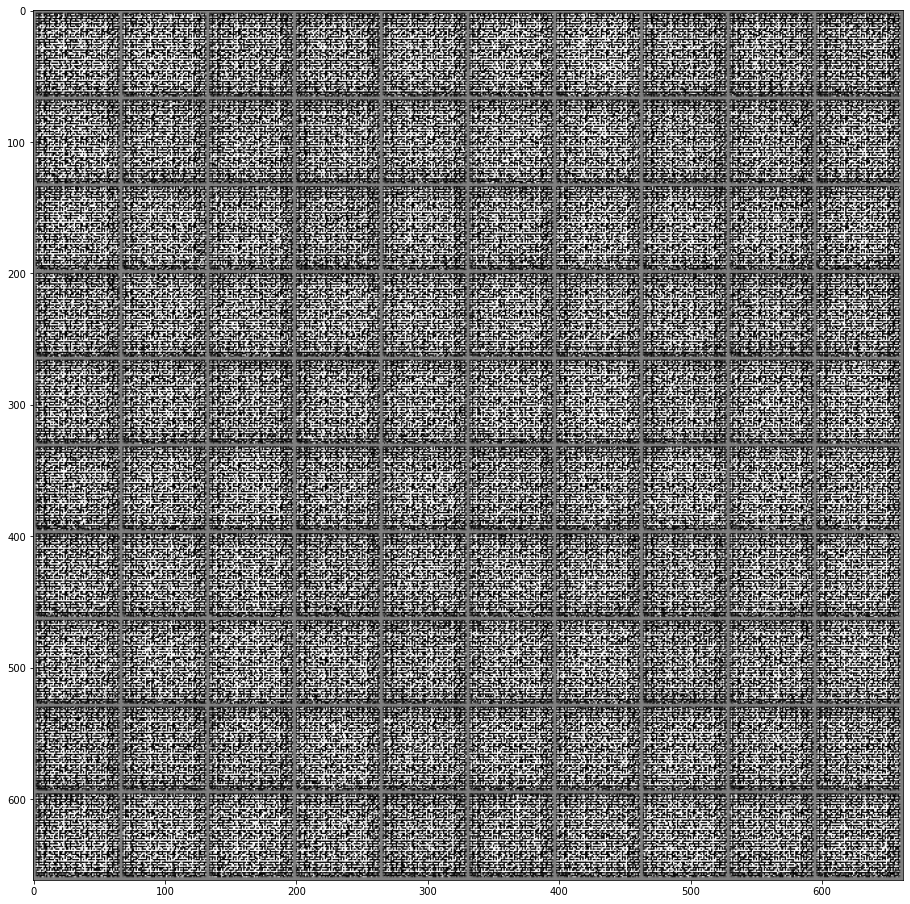

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2, Step: 470, Discriminator loss: 0.0084, Generator loss: 8.1212


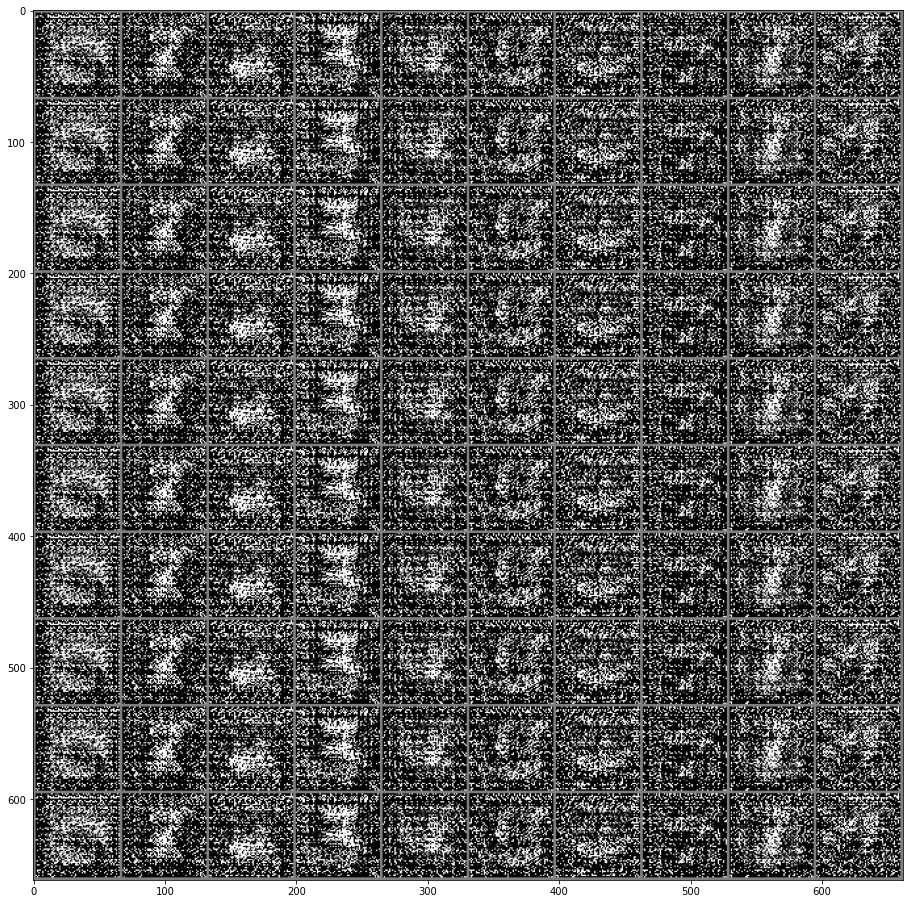

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3, Step: 939, Discriminator loss: 0.5767, Generator loss: 10.5028


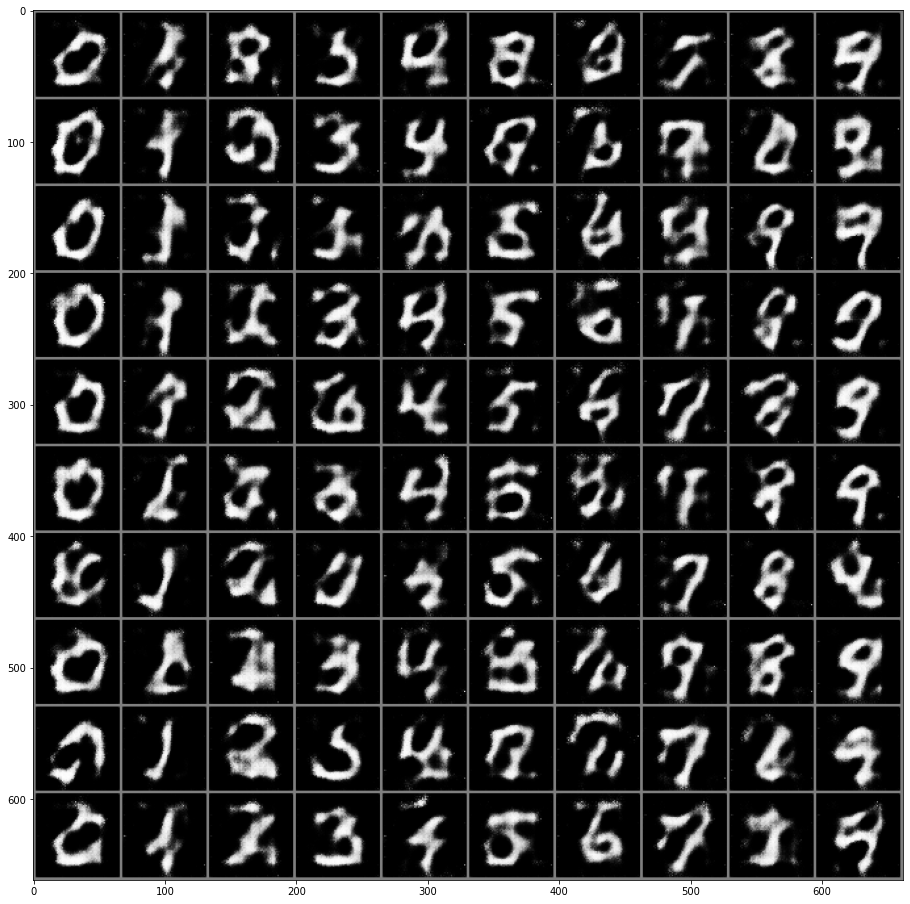

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4, Step: 1408, Discriminator loss: 1.2108, Generator loss: 11.5433


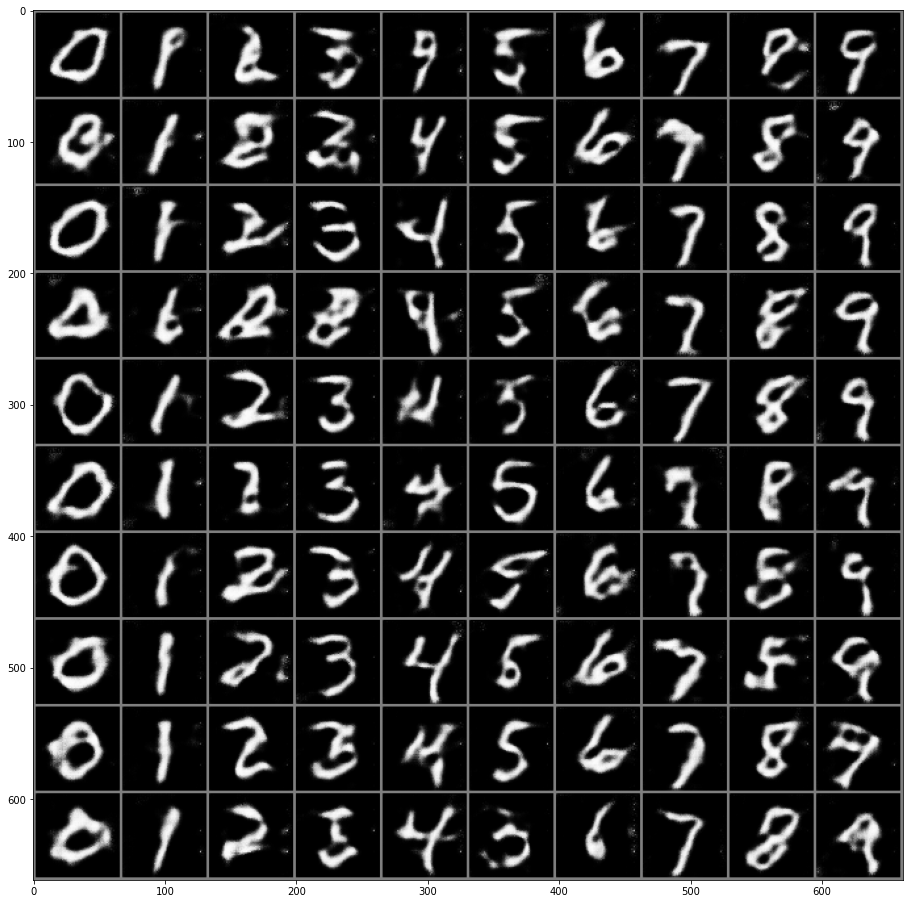

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5, Step: 1877, Discriminator loss: 1.8338, Generator loss: 12.6977


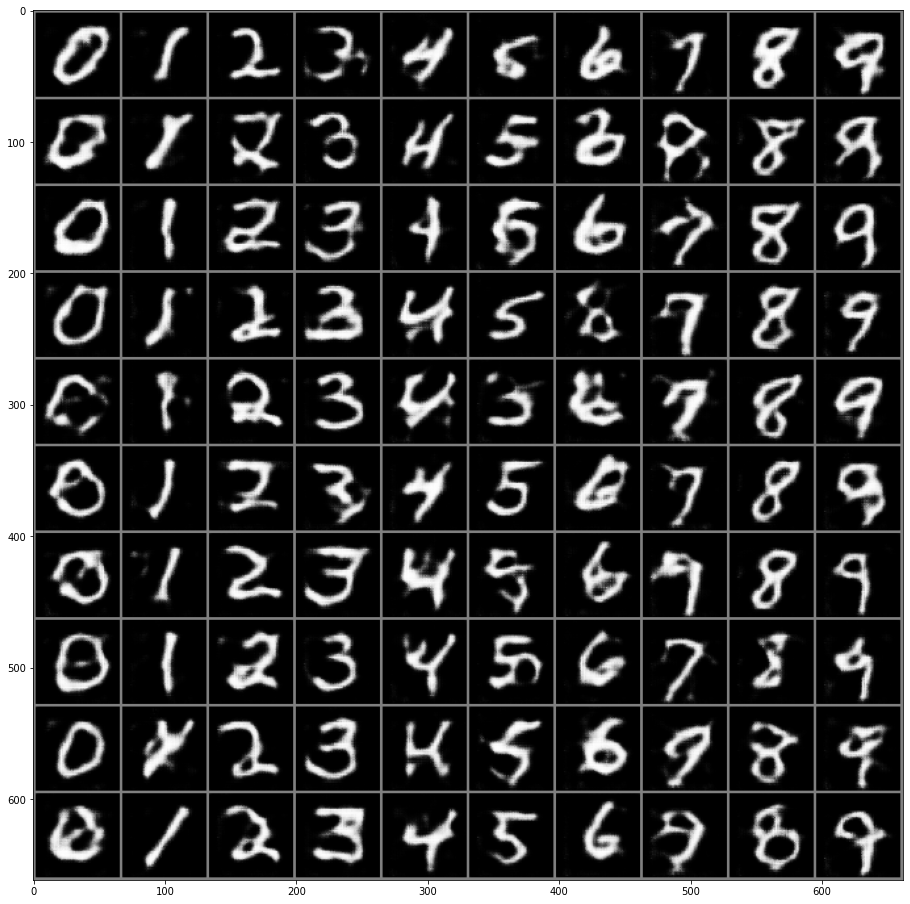

In [13]:
n_epochs=5

# Mean losses that will be displayed during training each delta steps.
mean_g_loss = 0.0
mean_d_loss = 0.0
delta_step = len(dataloader)

step = 0
for epoch in range(n_epochs):
    # Minibatch training.
    for images, labels in tqdm(dataloader, leave=False):
        images = images.to(device)
        labels = labels.to(device)

        # Number of examples, that number will not necessarily be equal to batch_size.
        num_examples = images.shape[0]
        oh = F.one_hot(labels, num_classes).unsqueeze(-1).unsqueeze(-1)

        # * Train the discriminator.
        # Genere false images.
        imgs_fake = g(
            z=torch.randn((num_examples, noise_dim, 1, 1), device=device), c=oh
        )

        # Convert oh of shape batch_size x num_classes x 1 x 1 to batch_size x num_classes x img_size x img_size.
        # Basically convert it to a one hot encoded 4D array such that only the correct class 2D array has all 1s
        # and the rest have 0s in them for every image. The discriminator needs a different shape for oh.
        oh_d = oh.clone().repeat(1, 1, img_size, img_size)

        d_opt.zero_grad()

        preds_fake = d(x=imgs_fake.detach(), c=oh_d)

        # The target is the truth values for fake images i.e. 0.
        d_loss = loss_fn(input=preds_fake, target=torch.zeros_like(preds_fake))

        # Probabilities assigned to real images, we do not need to detach since we minimize on real images.
        preds_real = d(x=images, c=oh_d)
        # The target is the truth values for real images i.e. 1.
        d_loss += loss_fn(input=preds_real, target=torch.ones_like(preds_real))

        # Average them.
        d_loss /= 2
        d_loss.backward()
        d_opt.step()

        # * Train the generator.
        g_opt.zero_grad()

        z = torch.randn((num_examples, noise_dim, 1, 1), device=device)
        imgs_new = g(z=z, c=oh)
        # Predictions on generated data.
        preds = d(x=imgs_new, c=oh_d)

        g_loss = loss_fn(input=preds, target=torch.ones_like(preds))
        g_loss.backward()
        g_opt.step()

        # For displaying loss after 'd_s' steps
        mean_g_loss += g_loss.item() / delta_step
        mean_d_loss += d_loss.item() / delta_step
        if step % delta_step == 0:
            print(
                f"Epoch: {epoch+1}, Step: {step + 1}, Discriminator loss: {mean_d_loss:.4f}, Generator loss: {mean_g_loss:.4f}"
            )

            # Validation.
            z = torch.randn(
                (num_classes * ncol, noise_dim, 1, 1), device=device
            )
            out = g(
                z=z,
                c=val_oh,
            )

            display(images=out, ncol=ncol)

            mean_disc_loss = 0
            mean_gen_loss = 0

        step += 1

# Save model

In [14]:
torch.save(g.state_dict(),"./mnist.pth")